In [1]:
import pandas as pd

all_postings = pd.read_csv('processed_description.csv')


### Split validation, training and test set

In [2]:
# define target class and input text
target = all_postings['salary_bin'].astype('category')
text = all_postings['processed_description']

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# split data into 70% training, 10% validation and 20% testing set
tfidf = TfidfVectorizer().fit(text)
X_tfidf =  tfidf.transform(text)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, target, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)


### TF-IDF Vectorization

In [13]:
# map salary bin to range
salary_info = {all_postings.salary_bin.unique()[i]: all_postings.salary_range.unique()[i] for i in range(len(all_postings.salary_bin.unique()))}
print(salary_info)

{1: '50k-100k', 0: '0-50k', 3: '150k+', 2: '100k-150k'}


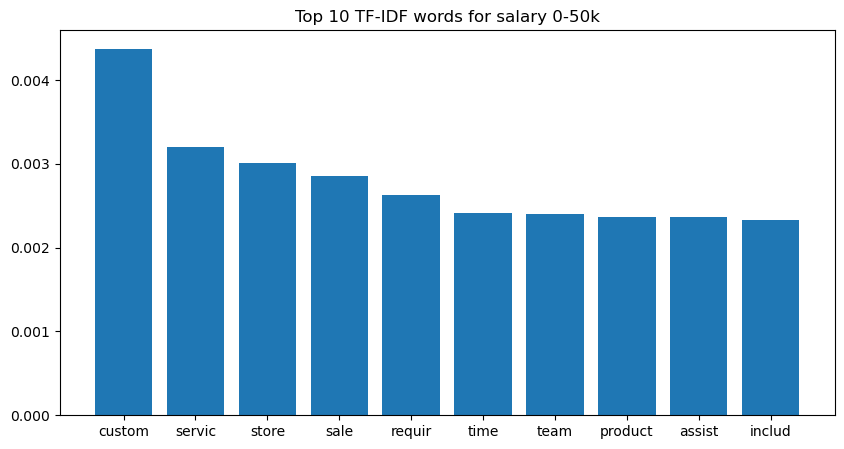

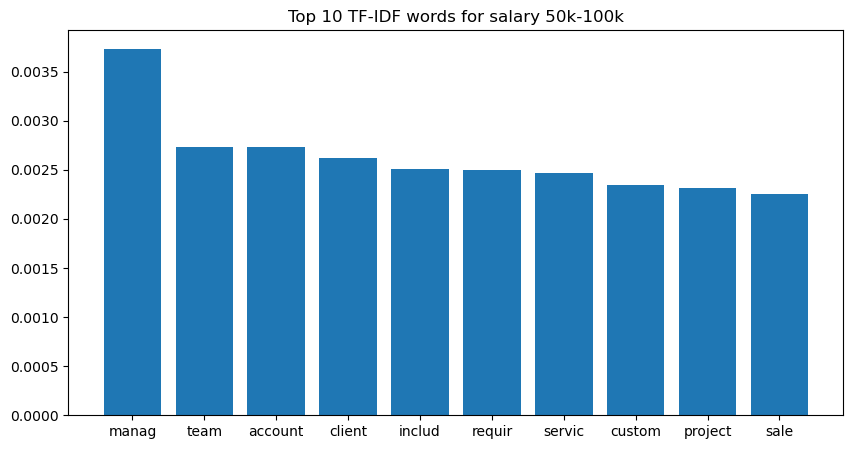

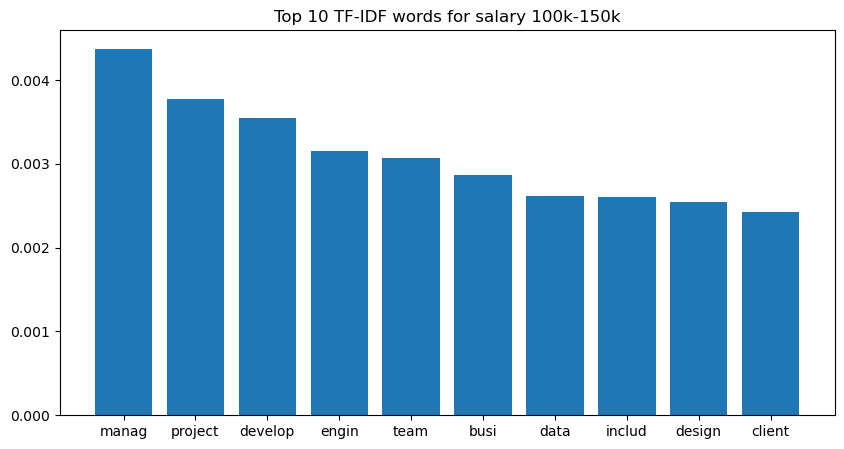

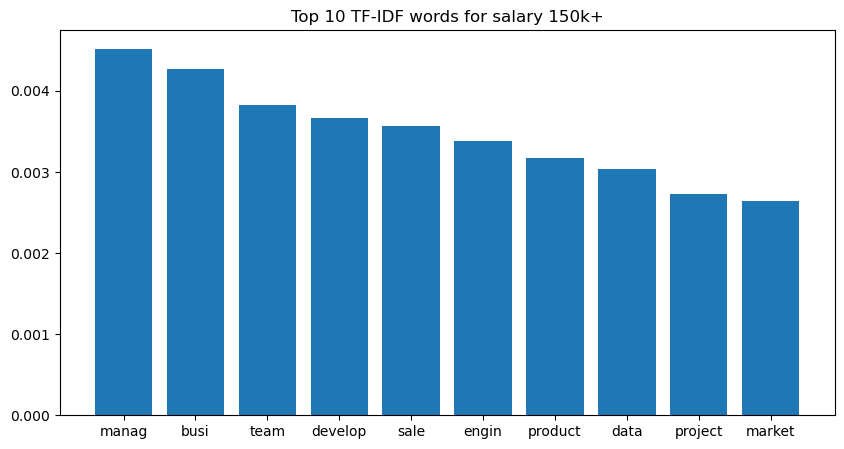

In [14]:
# graph top 10 tfidf words in each salary bin
import matplotlib.pyplot as plt


for salary_bin in target.cat.categories:
    X_train_bin = X_train[y_train == salary_bin]
    tfidf_sum = np.asarray(X_train_bin.sum(axis=0)).flatten()
    tfidf_sum = tfidf_sum / tfidf_sum.sum()
    sorted_idx = np.argsort(tfidf_sum)[::-1]
    feature_names = np.array(tfidf.get_feature_names_out())
    top_idx = sorted_idx[:10]
    top_values = tfidf_sum[top_idx]
    top_words = feature_names[top_idx]
    plt.figure(figsize=(10, 5))
    plt.bar(top_words, top_values)
    plt.title(f'Top 10 TF-IDF words for salary {salary_info.get(salary_bin)}')
    plt.show()

## ML Models 
### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, f1_score



# tune the hyperparameter C using the validation set
C_values = [0.01, 0.1, 1, 10, 100]
val_accuracy = []
for C in C_values:
    logistic_regression = LogisticRegression(C=C, max_iter=1000, penalty='l2',multi_class='ovr')
    logistic_regression.fit(X_val, y_val)
    
    y_val_pred = logistic_regression.predict(X_val)
    val_accuracy.append(accuracy_score(y_val, y_val_pred))

best_C = C_values[np.argmax(val_accuracy)]

# fit the model on the training set using the best C
logistic_regression = LogisticRegression(C=C, max_iter=1000, penalty='l2',  multi_class='ovr')
logistic_regression.fit(X_train, y_train)


# evaluate the model on the test set
y_test_pred = logistic_regression.predict(X_test)
y_test_pred_proba = logistic_regression.predict_proba(X_test)


logreg_f1 = f1_score(y_test, y_test_pred, average='weighted')
logreg_auc = roc_auc_score(y_test, y_test_pred_proba, average='weighted', multi_class='ovr')

print(f'Logistic Regression F1 Score: {logreg_f1}')
print(f'Logistic Regression AUC Score: {logreg_auc}')



Logistic Regression F1 Score: 0.6918831984198417
Logistic Regression AUC Score: 0.8751212310274334


### SVM

In [16]:
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score

class_weight = dict(all_postings['salary_bin'].value_counts(normalize=True))
# tune the hyperparameter C using the validation set
C_values = [0.01, 0.1, 1, 10, 100]
val_accuracy = []
for C in C_values:
    svm = LinearSVC(C=C, max_iter=10000, class_weight=class_weight,)
    svm.fit(X_val, y_val)
    
    y_val_pred = svm.predict(X_val)
    val_accuracy.append(accuracy_score(y_val, y_val_pred))

best_C = C_values[np.argmax(val_accuracy)]

# fit the model on the training set using the best C
svm = LinearSVC(C=best_C, max_iter=10000, class_weight=class_weight)
svm.fit(X_train, y_train)

# evaluate the model on the test set
y_test_pred = svm.predict(X_test)


svm_f1 = f1_score(y_test, y_test_pred, average='weighted')
svm_auc = roc_auc_score(y_test, y_test_pred_proba, average='weighted', multi_class='ovr')
print(f'Linear SVC F1 Score: {svm_f1}')
print(f'Linear SVC AUC Score: {svm_auc}')



/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/krysten/a

Linear SVC F1 Score: 0.67634181684857
Linear SVC AUC Score: 0.8751212310274334


### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
clf = RandomForestClassifier(n_estimators=1000, max_depth=50, bootstrap=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
print('AUC Score: ', roc_auc_score(y_test, clf.predict_proba(X_test), average='weighted', multi_class='ovr'))





Accuracy:  0.6258426966292134
F1 Score:  0.6046425109442652
AUC Score:  0.8757318885621388


### AdaBoost

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
clf = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred, average='weighted'))
print('AUC Score: ', roc_auc_score(y_test, clf.predict_proba(X_test), average='weighted', multi_class='ovr'))


Accuracy:  0.6097378277153558
F1 Score:  0.6036896391620549
AUC Score:  0.7558082111252612
